# **Simulator: The Lotka-Volterra Differential Equations** <br>


The Lotka-Volterra Model is a system of two ODEs:<br>
$$\frac{df}{dt}=\gamma_1 f-\gamma_2 fs$$
$$\frac{ds}{dt}=\gamma_3 fs-\gamma_4 s$$<br>
where the **variables** are<br>
$f$: population of fish (millions);<br>
$s$: population of seal (thousands);<br>
$t$: time (days), <br>
and the **parameters** (real positive numbers) are set as<br>
$\gamma_1=0.015$: the natural growing rate of fish when there is no seal;<br>
$\gamma_2=0.012$: the natural dying rate of fish due to predation;<br>
$\gamma_3=0.007$: $\frac{\gamma_3}{\gamma_2}$ describes how many caught fish let create a new seal;<br>
$\gamma_4=0.009$: the natural dying rate of seal when there is no fish.


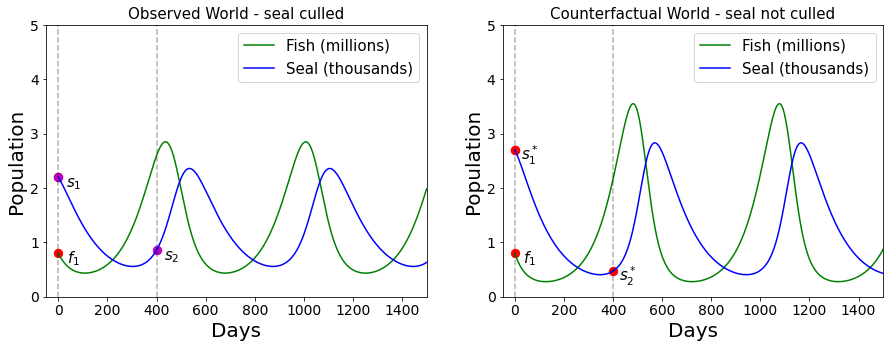

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from google.colab import files

plt.rcParams.update({'font.size': 14})


# define the ODEs
def odes(x,t,*args):
  f, s = x
  gamma1, gamma2, gamma3, gamma4 = args
  dfdt = gamma1*f - gamma2*f*s
  dsdt = gamma3*f*s - gamma4*s
  return dfdt, dsdt

# time (days): 0-1499 days
t = np.linspace(0, 1500, 1500)

# parameters of the differential equations:
gammas = 0.015, 0.012, 0.007, 0.009

# plt figure for plotting the solutions
fig = plt.figure(figsize=(15,5))
plot_titles = ["Observed World - seal culled", 
         "Counterfactual World - seal not culled"]

# two settings of the initial population of fish and seal
# 0.8 is the initial fish population for both settings
# 2.7 is the initial seal population if not culled
# 2.2 is the initial seal population if is culled 
for i, x0 in enumerate([(0.8, 2.2), (0.8, 2.7)]):

  # solve the ODEs
  sol = odeint(odes, x0, t, args=gammas)

  # add a subplot
  ax = fig.add_subplot(1,2,i+1)
  ax.plot(t, sol[:,0], 'green', label='Fish (millions)')
  ax.plot(t, sol[:,1], 'blue', label='Seal (thousands)')
  # ax.grid()
  ax.legend(loc=1, fontsize=15)
  ax.set_xlabel("Days", fontsize=20)
  ax.set_ylabel("Population", fontsize=20)

  plt.xlim(-50,1500)
  plt.ylim(0,5)

  ax.set_title(plot_titles[i], fontsize=15)
  ax.axvline(400, linestyle='--', c='k', alpha=0.3)
  ax.axvline(0, linestyle='--', c='k', alpha=0.3)
  # ax.axhline(sol[400,1], c='red')

  plt.annotate('$f_1$', (0, sol[0,0]), textcoords="offset points", xytext=(15,-10), ha='center', fontsize=15)
  plt.scatter(0, sol[0,1], color='red',s=70)
  plt.scatter(0, sol[0,0], color='red',s=70)

  if i ==0:
    plt.annotate('$s_2$', (400, sol[400,1]), textcoords="offset points", xytext=(15,-10), ha='center', fontsize=15)
    plt.annotate('$s_1$', (0, sol[0,1]), textcoords="offset points", xytext=(15,-10), ha='center', fontsize=15)
    plt.scatter(400, sol[400,1], color='m',s=70)
    plt.scatter(0, sol[0,1], color='m',s=70)
  else:
    plt.annotate('$s_2^*$', (400, sol[400,1]), textcoords="offset points", xytext=(15,-10), ha='center', fontsize=15)
    plt.annotate('$s_1^*$', (0, sol[0,1]), textcoords="offset points", xytext=(15,-10), ha='center', fontsize=15)
    plt.scatter(400, sol[400,1], color='red',s=70)
    plt.scatter(0, sol[0,1], color='red',s=70)


  # ax.axhline(sol[0,1], c='m')

plt.show()
fig.savefig("ground_truth.pdf", bbox_inches='tight')
#files.download("ground_truth.pdf")


As in the student's report, we will only focus on the seal population on day 400 (as indicated by the red lines).<br> 
The initial seal population are indicated by the magenta lines.<br>
Here, the counterfactual question we ask is "**what would
the seal population have been on day 400 had it not been culled on day 0?**"<br>
The figure on the RHS above is the ground truth answer from the ODE simulator.

# **Causality as Probabilistic Inference**

We would like to train a probabilistic model to answer this counterfacutal question. This involves learning the model parameters $\theta$ from the training set $\mathcal{D}$ (**the student's report omits the details of how to do this**) as well as inferring the counterfactual world and the latent variable (initial fish population) given the observed world and the learned model parameters (**the student's report contains relatively more details about this, but still the MC sampling procedure is ommited**).

Now we need to obtain the training set $\mathcal{D}=\{(f_{1,n},s_{1,n},\tau=400,f_{2,n},s_{2,n})\}_{n=1}^N$ from the ODEs with different initial conditions (**the student's report omits what exactly the dataset he used consists of, e.g. how many data points? with what initial conditions those data points were sampled from the ODEs?**).<br> 
We also need to sample the data for the observed world $(s_1,s_2)$ and counterfacutal world $(s_1^*,s_2^*)$ from the ODEs but do not use them for training (only for inference and evaluating results).

# **Sampling Data from the ODE Simulator for Training** <br>



Assume that we know $F_1\sim\log\mathcal{N}(0,1)$ and $S_1\sim\log\mathcal{N}(0,1)$. Now we sample the training set $\mathcal{D}=\{(f_{1,n},s_{1,n},\tau=400,f_{2,n},s_{2,n})\}_{n=1}^N$ from the ODE simulator.

In [ ]:
np.random.seed(1)  # random seed for reproducibility

dataset = []
num_data = 5000  # the number of data points to be sampled

t = np.linspace(0, 1500, 1500)
gammas = 0.015, 0.012, 0.007, 0.009  # parameters of the simulator

for i in range(num_data):
  f1 = np.random.lognormal()
  s1 = np.random.lognormal()
  x0 = (f1, s1)
  sol = odeint(odes, x0, t, args=gammas)
  f2 = sol[400,0]
  s2 = sol[400,1]
  dataset.append((f1,s1,f2,s2))

dataset = np.array(dataset)  # Data matrix D of size N x 4 (f1,s1,f2,s2)
print(dataset[:20])

[[5.07509561 0.54239736 0.14392723 0.41641172]
 [0.58968207 0.34199176 0.18597035 1.75946788]
 [2.37597441 0.10010469 0.0306746  0.79315772]
 [5.72482376 0.46710234 0.08142538 0.41174499]
 [1.37580511 0.77929129 0.70220006 1.11032824]
 [4.31504579 0.12743604 0.02242297 0.57922157]
 [0.72439591 0.68109441 0.51952018 1.67937955]
 [3.10734742 0.33290728 0.17665485 0.57490162]
 [0.84161871 0.41567216 0.2634871  1.39847125]
 [1.04311742 1.79107359 2.09165054 1.18697195]
 [0.33266504 3.14157325 1.29995646 0.20842852]
 [2.46351877 1.65283887 1.27475668 0.6136734 ]
 [2.46170931 0.50473191 0.38110114 0.66618449]
 [0.88436074 0.39228391 0.24590186 1.34462234]
 [0.76499339 1.69953633 2.22338986 1.45363991]
 [0.50074377 0.67249976 0.51861003 2.12870531]
 [0.50299618 0.42946903 0.25907227 1.99222068]
 [0.51107132 0.98741526 1.01114547 2.22038367]
 [0.32715855 1.2641699  2.34654031 2.32611786]
 [5.25827054 2.10022433 0.25314052 0.29619447]]


# **Modelling, Assumptions and Learning**

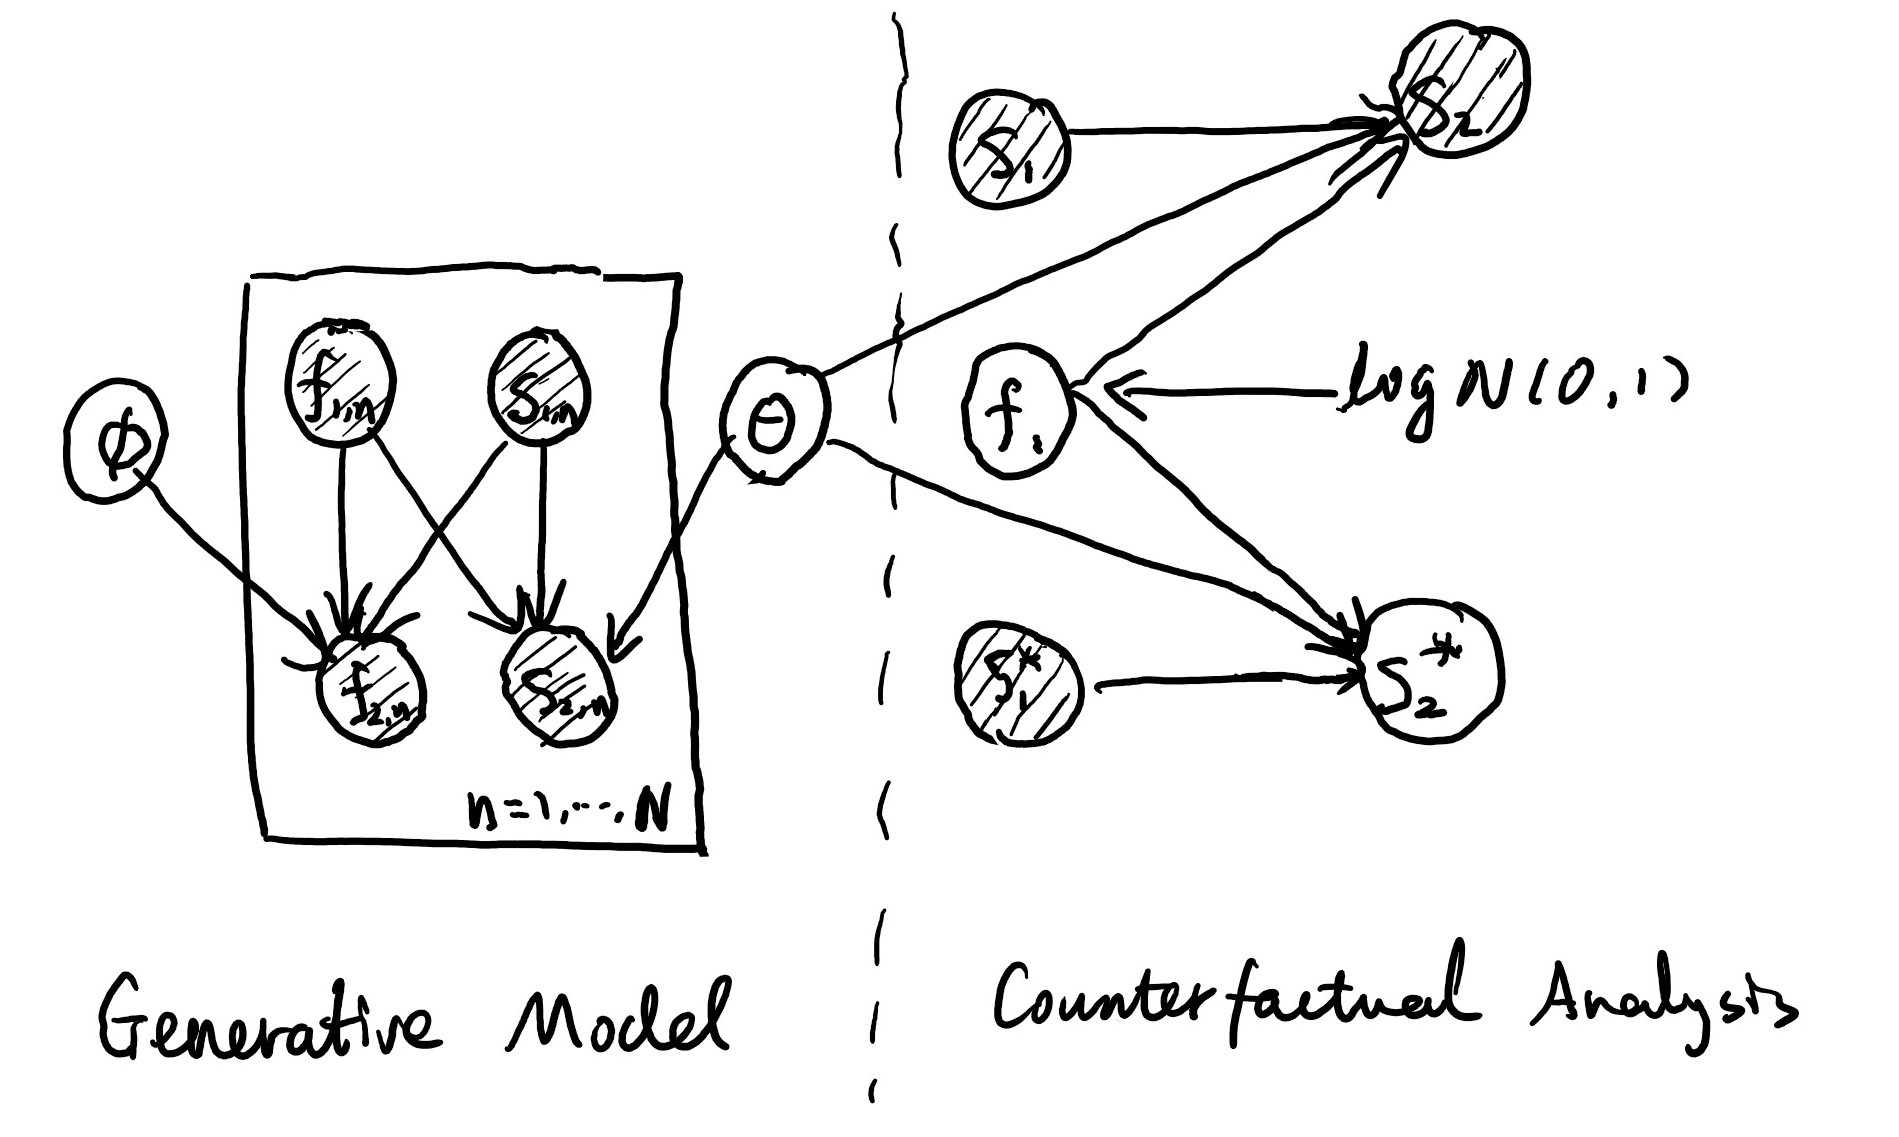

For the generative model on the LHS, we have<br>
$$p(\mathcal{D},\theta)=p(\mathcal{D}|\theta)p(\theta)=p(\theta)\prod_{n=1}^N p(f_{1,n})p(s_{1,n})p(f_{2,n}|f_{1,n},s_{1,n},\phi)p(s_{2,n}|f_{1,n},s_{1,n},\theta).$$<br>
**The student's report suggests that we approximate the model parameters $\theta$ by doing a maximum likelihood estimate using $\mathcal{D}$ only:
$$\max_{\theta} \log p(\mathcal{D}|\theta)=\max_{\theta} \sum_{n=1}^N \log p(s_{2,n}|f_{1,n},s_{1,n},\theta) $$**
**and later in the inference stage when we need to take expectation w.r.t. some distribution of $\theta$ we just plug in $\theta_{ML}$**.<br><br>
For the model for counterfacutal analysis on the RHS, as in the student's report, we have<br>
$$p(s_1,s_2,f_1,s_1^*,s_2^*,\mathcal{D},\theta)=p(s_1)p(s_2|f_1,s_1,\theta)p(f_1)q(s_1^*)q(s_2^*|f_1,s_1^*,\theta)p(\mathcal{D},\theta).$$


Assumptions:<br>
1. $F_1\sim\log\mathcal{N}(0,1)$ and $S_1\sim\log\mathcal{N}(0,1)$;
2. the mechanism determining the final seal population in the
observed world is the same as that in the counterfactual world, that is<br>
$$p(s_2|f_1,s_1,\theta)=q(s_2|f_1,s_1,\theta);$$
3. setting $q(s_1)=\delta(s_1-s_1^*)$ so that marginalizing over it is equivalent to conditioning on $s_1^*$.




The only distribution for which we need to learn the parameters is $p(s_2|f_1,s_1,\theta)$.<br>
We assume that it is a Gaussian distribution
$$p(s_2|f_1,s_1,\theta)=
\mathcal{N}(s_2;g_{\theta}(f_1,s_1),\sigma^2)$$
with mean parameterized by a neural network $g_{\theta}(f_1,s_1)$ and variance $\sigma=0.01$ fixed.

# **Learning**

In [ ]:
# TRAIN DATA
data_split = 0.8
split_index = int(0.8 * dataset.shape[0])
train_X__f1_s1 = dataset[:split_index,:2]
train_Y__s2 = dataset[:split_index,3]

# TEST DATA
test_X__f1_s1 = dataset[split_index:,:2]
test_Y__s2 = dataset[split_index:,3]

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Layer,Dense, Dropout, Activation

In [ ]:
# SIMPLE BASELINE - achieves MSE=0.04 after 20 epochs, trained on 1600 data points, LR=0.001   
# TO FIX: not sure why but sometimes doesn't converge and then we need to run it multiple times
def simple_baseline_DNN(input_shape=(2)):
  model_input = Input(shape=input_shape)  # a vector: [f1,s1]

  x = Dense(100, activation='relu')(model_input)
  x = Dense(100, activation='relu')(x)

  mean_s2 = Dense(1, activation="linear")(x)  # seal population should be positive -> use 'relu'
  model = Model(inputs=model_input, outputs=mean_s2, name='simple_FC_network')
  return model


model = simple_baseline_DNN(input_shape=(2))
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[keras.metrics.MeanSquaredError()])
model.summary()
history = model.fit(train_X__f1_s1, train_Y__s2, 
          validation_data=(test_X__f1_s1, test_Y__s2), epochs=100)

Model: "simple_FC_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_24 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_25 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 101       
Total params: 10,501
Trainable params: 10,501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
125/125 [==============================] - 1s 3ms/step - loss: 1.4218 - mean_squared_error: 1.4218 - val_loss: 0.4673 - val_mean_squared_error: 0.4673
Epoch 2/100
125/125 [==============================] - 0s 2ms/step - loss: 0.370

In [ ]:
# VISUALISATION OF MODEL
show = 10

y_pred = model.predict(test_X__f1_s1)
for true, pred in zip(test_Y__s2[:show], y_pred[:show]):
  print('True: ', str(true), '  ', 'Pred: ', str(pred[0]))

True:  5.008942507944181    Pred:  4.863333
True:  0.4560044678013213    Pred:  0.4579921
True:  0.87482704311607    Pred:  0.8797201
True:  0.17793917619070448    Pred:  0.18517725
True:  2.184727487817079    Pred:  1.9487592
True:  1.4950409660929087    Pred:  1.4970889
True:  1.3837137220028144    Pred:  1.4068563
True:  0.3142888216527384    Pred:  0.284724
True:  2.9291396281354722    Pred:  2.8529034
True:  2.320263902281332    Pred:  2.3272913


# **Inference**

Basically this part will just follow the student's report. **The only thing that we need to think about is how to do the MC sampling from $p(s_2^*|s_1,s_2,s_1^*,\mathcal{D})$ and from the posterior of $f_1$.**

$$
\begin{aligned}
p(s_2^*|s_1,s_2,s_1^*,\mathcal{D})&\propto \mathbb{E}_{p(\theta|\mathcal{D},s_1,s_2)}\left[\mathbb{E}_{p(f_1)}\left[p(s_2^*|s_1^*,f_1,\theta)p(s_2|s_1,f_1,\theta)\right]\right]\\
&\approx\mathbb{E}_{p(f_1)}\left[p(s_2^*|s_1^*,f_1,\theta_{ML})p(s_2|s_1,f_1,\theta_{ML})\right]\\
&\approx\frac{1}{L}\sum_{l=1}^Lp(s_2^*|s_1^*,f_1^{(l)},\theta_{ML})p(s_2|s_1,f_1^{(l)},\theta_{ML}),\quad f_1^{(l)}\sim p(f)\\
&\propto \sum_{l=1}^Lw^{(l)}p(s_2^*|s_1^*,f_1^{(l)},\theta_{ML}),\quad w^{(l)}=p(s_2|s_1,f_1^{(l)},\theta_{ML})\\
\implies p(s_2^*|s_1,s_2,s_1^*,\mathcal{D})&\approx \sum_{l=1}^L\pi^{(l)}p(s_2^*|s_1^*,f_1^{(l)},\theta_{ML}),\quad \pi^{(l)}=\frac{w^{(l)}}{\sum_{j=1}^Lw^{(j)}}.
\end{aligned}
$$

mean 0.4552296413842894
0.46


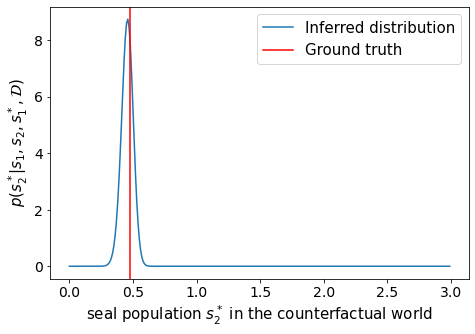

true 0.4741479620920496


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from scipy.stats import norm
vector_length = 100
sigma = history.history['val_mean_squared_error'][-1] ** 0.5 # set sigma to training rmse
#sigma = 0.07
s1 = np.ones(vector_length) * 2.2  # known constant - post cull initial seal population
s1_star = np.ones(vector_length) * 2.7  # known constant - pre cull initial seal population
f1_samples = np.random.lognormal(size=vector_length)  # samples f1 from a log normal prior log[N(0,1)]

# 1) Compute the mean of p(s2|s1,f1^{(i)) for all f1_samples
f1_s1 = np.stack((f1_samples, s1), axis=1)
s2_means = model.predict(f1_s1).flatten()

# 2) Compute the mean of p(s2*|s1*,f1^{(i)) for all f1_samples
f1_s1_star = np.stack((f1_samples, s1_star), axis=1)
s2_star_means = model.predict(f1_s1_star).flatten()

# 3) Evaluate w_i = p(s2=sol[400,1]|s1,f1^{(i)})
x0 = (0.8, 2.2)
t = np.linspace(0, 1500, 1500) 
gammas = 0.015, 0.012, 0.007, 0.009
sol = odeint(odes, x0, t, args=gammas)

w = []
for i in range(vector_length):
  w.append(norm.pdf(sol[400,1], loc=s2_means[i], scale=sigma))
w = np.array(w)
w /= np.sum(w) # normalizing

# 4) Mixture of Gaussian
x_line = np.arange(0.0, 3.0, 0.01)
y_line = w[0] * norm.pdf(x_line, loc=s2_star_means[0], scale=sigma)
for i in range(1,vector_length):
  y_line += w[i] * norm.pdf(x_line, loc=s2_star_means[i], scale=sigma)
mean_ = np.sum(y_line*x_line*0.01)
print('mean', mean_)
print(x_line[np.argmax(y_line)])

# 5) Ground truth
x0 = (0.8, 2.7)
t = np.linspace(0, 1500, 1500) 
gammas = 0.015, 0.012, 0.007, 0.009
sol_star = odeint(odes, x0, t, args=gammas)

fig = plt.figure(figsize=(7.5,5))
ax = fig.add_subplot(111)
ax.plot(x_line, y_line, label='Inferred distribution')
ax.set_xlabel('seal population $s_2^*$ in the counterfactual world', fontsize=15)
ax.set_ylabel('$p(s_2^*|s_1,s_2,s_1^*,\mathcal{D})$', fontsize=15)
ax.axvline(sol_star[400,1], c='red', label='Ground truth')
ax.legend(fontsize=15)
plt.show()
print('true', sol_star[400,1])

fig.savefig("sec2_supervised_s2star.pdf", bbox_inches='tight')
files.download("sec2_supervised_s2star.pdf")

Inference for the posterior of $f_1$:
$$
\begin{aligned}
p(f_1|s_1,s_2,s_1^*,\mathcal{D})&=\mathbb{E}_{p(\theta|\mathcal{D},s_1,s_2)}[p(f_1|s_1,s_2,\theta)]\\
&\approx p(f_1|s_1,s_2,\theta_{ML})\\
&\propto p(s_2|s_1,f_1,\theta_{ML})p(f_1)
\end{aligned}
$$

mean: 0.8309206815695025
0.84


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

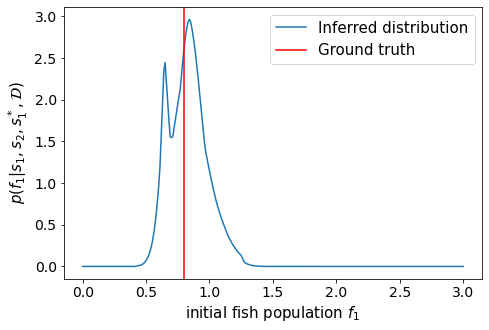

In [ ]:
from scipy.stats import lognorm

grid = 0.01

f1 = np.arange(0.0, 3.0+grid, grid)
pf1_prior = lognorm.pdf(f1,1)
s1 = np.ones(f1.shape) * 2.2
f1_s1 = np.stack((f1, s1), axis=1)
s2_means = model.predict(f1_s1).flatten()
ps2_post = [norm.pdf(sol[400,1], loc=i, scale=sigma) for i in s2_means]
pf1_post = np.multiply(ps2_post,pf1_prior)
pf1_post /= np.sum(pf1_post * grid)
pf1_post_mean = np.sum(pf1_post * f1 * grid)
print('mean:',pf1_post_mean)
print(f1[np.argmax(pf1_post)])

fig = plt.figure(figsize=(7.5,5))
ax = fig.add_subplot(111)
ax.plot(f1,pf1_post, label='Inferred distribution')
ax.set_xlabel('initial fish population $f_1$', fontsize=15)
ax.set_ylabel('$p(f_1|s_1,s_2,s_1^*,\mathcal{D})$', fontsize=15)
ax.axvline(0.8, c='red', label='Ground truth')
ax.legend(fontsize=15)
plt.plot()

fig.savefig("sec2_supervised_f1.pdf", bbox_inches='tight')
files.download("sec2_supervised_f1.pdf")

# **Case 2: 1-latent variable** (that is not a confounder)

### **Problem statement**
In the above example we observed initial fish population, thus we could use standard supervised learning for the modeling part of the counterfactual analysis. We could easily find $p_{\theta}(s_2|s_1,f_1)$ by identifing optimal $\theta_{ML}$ via maximum likelihood estimation.

However, when $f_1$ becomes latent, we need to integrate over all possible values of $f_1$, as presented in equation below: \\
$p(s_2|s_1,\theta)=\int p(f_1|\theta)p(s_2|s_1,f_1,\theta)df_1$ \\
(we want to weight each $p(s_2|s_1,f_1,\theta)$ by the probability of $f_1$ for given set of parameters $\theta$ )
However, it is intractable to integrate over all values of the latent variable $f_1$.


We can find a solution to this problem using Variational Autoencoders where in addition to modelling a decoder $p(s_2|s_1,f_1,\theta)$ we also define an enocoder $q(f_1|s_1,s_2,\phi)$ which approximates the posterior density $p(f_1|s_1,s_2,\theta)$ (which is also not tractable).

This will allow us to define a lower bound on the likelihood of model parameters $\theta$, which is tractable and we can optimise it using Variational Autoencoder network. The Lower bound can be derived as follows:


### **Identifying Lower Bound** (VAE objective function)
$$
  \begin{aligned}
  \log p_{\theta}\left(s_1,s_2\right) &=\mathbf{E}_{f_1 \sim q_{\phi}\left(f_1 \mid s_1,s_2\right)}\left[\log p_{\theta}\left(s_1,s_2\right)\right] \\
  &=\mathbf{E}_{f_1}\left[\log \frac{p_{\theta}\left(s_1, s_2 | f_1 \right) p_{\theta}(f_1)}{p_{\theta}\left(f_1 \mid s_1, s_2\right)}\right] \\
  &=\mathbf{E}_{f_1}\left[\log \frac{p_{\theta}\left(s_1, s_2 \mid f_1\right) p_{\theta}(f_1)}{p_{\theta}\left(f_1 \mid s_1, s_2\right)} \frac{q_{\phi}\left(f_1 \mid s_1, s_2\right)}{q_{\phi}\left(f_1 \mid s_1, s_2\right)}\right] \\
&=\mathbf{E}_{f_1}\left[\log p_{\theta}\left( s_1, s_2 \mid f_1\right)\right]-\mathbf{E}_{f_1}\left[\log \frac{q_{\phi}\left(f_1 \mid s_1, s_2\right)}{p_{\theta}(f_1)}\right] +\mathbf{E}_{f_1}\left[\log \frac{q_{\phi}\left(f_1 \mid x_{0}^{(i)}\right)}{p_{\theta}\left(f_1 \mid s_1, s_2\right)}\right] \\
&=\mathbf{E}_{f_1}\left[\log p_{\theta}\left(s_1, s_2 \mid f_1\right)\right]-D_{K L}\left(q_{\phi}\left(f_1 \mid s_1, s_2\right) \| p_{\theta}(f_1)\right)+D_{K L}\left(q_{\phi}\left(f_1 \mid s_1, s_2\right) \| p_{\theta}\left(f_1 \mid s_1, s_2\right)\right)

  \end{aligned}
$$

In the last line the third term (or second KL divergence term) is not tractable, however we know that KL divergence has to be equal or greater then zero. Therefore we can define a lower bound as: \\
$$
\begin{aligned}
\log p_{\theta} \left(s_1,s_2\right) &\geq \mathbf{E}_{f_1}\left[\log p_{\theta}\left(s_1, s_2 \mid f_1\right)\right]-D_{K L}\left(q_{\phi}\left(f_1 \mid s_1, s_2\right) \| p_{\theta}(f_1)\right) \\
&= \mathbf{E}_{f_1}\left[\log p_{\theta}\left(s_2 \mid s_1, f_1\right)  p_{\theta}\left(s_1\right) \right]-D_{K L}\left(q_{\phi}\left(f_1 \mid s_1, s_2\right) \| p_{\theta}(f_1)\right)
\end{aligned}
$$

### **Modeling**
In order to find $\theta_{ML}$ and $\phi_{ML}$ we need to construct a VAE neural netowork.



In [ ]:
# VAE data [s1, s2]
data_split = 0.8
split_index = int(0.8 * dataset.shape[0])
train__s1 = dataset[:split_index,1].astype('float32')
train__s2 = dataset[:split_index,3].astype('float32')

# TEST
test__s1 = dataset[split_index:,1].astype('float32')
test__s2 = dataset[split_index:,3].astype('float32')

### **Note on the code below** (Solved) :
The VAE below uses GAUSSIAN priors. However what we need are log normal gaussian priors. With these, there is no analytical solution for the KL divergence term. However, we want to keep the log normla priors on f1 and s1 as the seal and fish populations are positive. What we need to do next to make the code below work for our case is to figure out **how to compute KL divergence for non-gaussian priors**, and we also need to **modify Gausian priors to log normal priors** in the code below. 

### **Solution proposed by Wenlin** (to the problem above ^):

(Wenlin) log-normal VAE

$$
\begin{aligned}
\log p_{\theta} \left(s_2|s_1\right) &\geq \mathbf{E}_{f_1\sim q_{\phi}}\left[\log p_{\theta}\left(s_2|s_1, f_1\right)\right]-D_{K L}\left(q_{\phi}\left(f_1 \mid s_1, s_2\right) \| p_{\theta}(f_1)\right) \\
&= \mathbf{E}_{f_1\sim q_{\phi}}\left[\log p_{\theta}\left(s_2 \mid s_1, f_1\right) \right]-D_{K L}\left(q_{\phi}\left(f_1 \mid s_1, s_2\right) \| p_{\theta}(f_1)\right)
\end{aligned}
$$

Prior: 
$$p_{\theta}(f_1)=\log\mathcal{N}(f_1;0,1)$$

Encoder (approximate posterior): 
$$q_{\phi}(f_1|s_1,s_2)=\log\mathcal{N}(f_1;\mu(s_1,s_2),\sigma(s_1,s_2)^2)$$

Transformation **(this is the only change I made in code, i.e. add an exp**):
$$f_1|s_1,s_2=\exp(\mu(s_1,s_2)+\sigma(s_1,s_2)\epsilon)\sim q_{\phi}(f_1|s_1,s_2),\quad \text{where } \epsilon\sim\mathcal{N}(0,1)$$

KL between two log-normals is tractable: **the formula is identical for that between two Gaussians**
$$\text{KL}(q_{\phi}(f_1|s_1,s_2)||p_{\theta}(f_1))=-\frac{1}{2}\sum_{j=1}^d\left(1+\log\sigma_j(s_1,s_2)^2-\mu_j(s_1,s_2)^2-\sigma_j(s_1,s_2)^2\right),\quad \text{in this example $d=dim(f_1)=1$}
$$

In [ ]:
# building VAE NN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Layer,Dense, Dropout, Activation, Concatenate
from keras import backend as K
import sys



latent_dim = 1

# given mean and log variance provided by encoder -> sample f1
class Sampling(Layer):
  def call(self, inputs):
    f1_mean, f1_log_var = inputs
    batch = tf.shape(f1_mean)[0]
    dim = tf.shape(f1_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return K.exp(f1_mean + tf.exp(0.5 * f1_log_var) * epsilon)


# decoder for p(s2|s1,f1,theta)
def decoder_NN(input_shape=(2)):

  model_input = Input(shape=input_shape)  # input: [f1,s1]
  x = Dense(100, activation='relu')(model_input)
  x = Dense(100, activation='relu')(x)
  x = Dense(1, activation='linear')(x)
  decoder = Model(inputs=model_input, outputs=x, name='decoder')
  # decoder.summary()
  return decoder


# encoder for q(f1|s1,s2,phi)
def encoder_NN(input_shape=(2)):

  model_input = Input(shape=input_shape)  # input: [s1,s2]
  x = Dense(100, activation='relu')(model_input)
  x = Dense(100, activation='relu')(x)

  # NN computes mean and log_variance of f1
  f1_mean = Dense(latent_dim, activation='linear')(x)
  f1_log_var = Dense(latent_dim, activation='linear')(x)

  # for predicted mean and variance sample f1
  f1_sample = Sampling()([f1_mean, f1_log_var])

  # model outputs a touple of (f1_mean, f1_log_var, f1_sample)
  encoder = Model(inputs=model_input, outputs=[f1_mean, f1_log_var, f1_sample], name="encoder")
  # encoder.summary()
  return encoder



def vae(encoder, decoder):
  
  input_s1 = Input(shape=1)
  input_s2 = Input(shape=1)
  encoder_input = Concatenate()([input_s1, input_s2])
  f1_mean, f1_log_var, f1 = encoder(encoder_input)

  decoder_input = Concatenate()([f1, input_s1])
  s2_decoded = decoder(decoder_input)

  vae = Model(inputs=[input_s1, input_s2], outputs=[s2_decoded], name="vae")



  # ADDING CUSTOM LOSS FUNCTION
  # reconstruction_loss + KL_divergence

  # WITH 'kl_loss'
  original_dim = 2
  reconstruction_loss = tf.keras.losses.MeanSquaredError()(input_s2, s2_decoded)
  reconstruction_loss *= original_dim
  kl_loss = 1 + f1_log_var - K.square(f1_mean) - K.exp(f1_log_var)
  kl_loss = K.sum(kl_loss, axis=-1)
  kl_loss *= -0.5
  vae_loss = K.mean(reconstruction_loss + kl_loss)
  vae.add_loss(vae_loss)

  # # WITHOUT 'kl_loss'
  # original_dim = 2
  # reconstruction_loss = tf.keras.losses.MeanSquaredError()(input_s2, s2_decoded)
  # reconstruction_loss *= original_dim
  # vae.add_loss(reconstruction_loss)

  return vae



encoder = encoder_NN()
decoder = decoder_NN()
vae_model = vae(encoder, decoder)
vae_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), metrics=[keras.metrics.MeanSquaredError()])

history = vae_model.fit([train__s1, train__s2], train__s2, validation_data=([test__s1, test__s2], test__s2), epochs=100)


Epoch 1/100
125/125 [==============================] - 1s 4ms/step - loss: 2.5886 - mean_squared_error: 1.2009 - val_loss: 1.3611 - val_mean_squared_error: 0.4195
Epoch 2/100
125/125 [==============================] - 0s 3ms/step - loss: 1.1949 - mean_squared_error: 0.3580 - val_loss: 1.5014 - val_mean_squared_error: 0.5651
Epoch 3/100
125/125 [==============================] - 0s 3ms/step - loss: 1.1999 - mean_squared_error: 0.3966 - val_loss: 1.0303 - val_mean_squared_error: 0.2760
Epoch 4/100
125/125 [==============================] - 0s 3ms/step - loss: 1.0010 - mean_squared_error: 0.2760 - val_loss: 1.0039 - val_mean_squared_error: 0.3120
Epoch 5/100
125/125 [==============================] - 0s 3ms/step - loss: 1.0213 - mean_squared_error: 0.2956 - val_loss: 1.0515 - val_mean_squared_error: 0.3257
Epoch 6/100
125/125 [==============================] - 0s 3ms/step - loss: 0.9644 - mean_squared_error: 0.2872 - val_loss: 1.4333 - val_mean_squared_error: 0.2909
Epoch 7/100
125/125 [=

In [ ]:
# visualise VAE output
show = 20

test__f1 = dataset[split_index:,0].astype('float32')
test__s1 = dataset[split_index:,1].astype('float32')
test = np.stack([test__f1, test__s1], axis=1)


s2_pred = decoder.predict(test)
for true, pred in zip(test__s2[:show], s2_pred[:show]):
  print('True: ', str(true), '  ', 'Pred: ', str(pred[0]))

True:  5.0089426    Pred:  0.6401505
True:  0.45600447    Pred:  3.3210652
True:  0.874827    Pred:  1.7919396
True:  0.17793918    Pred:  0.109960765
True:  2.1847274    Pred:  0.9995555
True:  1.495041    Pred:  1.2815188
True:  1.3837137    Pred:  1.1741532
True:  0.31428882    Pred:  0.73000497
True:  2.9291396    Pred:  0.7350692
True:  2.3202639    Pred:  0.8492023
True:  0.37093148    Pred:  0.2920073
True:  0.3212937    Pred:  0.22317354
True:  1.4448333    Pred:  1.1682398
True:  2.4679213    Pred:  0.8316805
True:  0.6267975    Pred:  1.5586149
True:  0.37092054    Pred:  0.39344275
True:  0.41633594    Pred:  2.3390403
True:  0.1419643    Pred:  0.13549307
True:  1.842336    Pred:  0.97217053
True:  1.0211337    Pred:  0.70747566


*Inference*

mean: 0.387404525387006
0.34


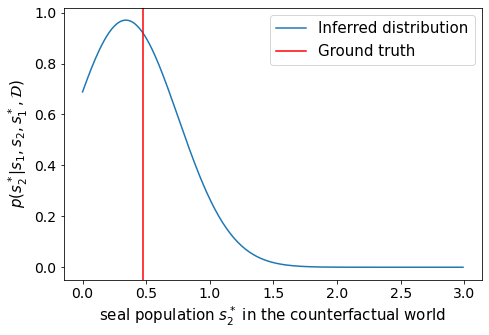

true 0.4741479620920496


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from scipy.stats import norm
vector_length = 100
sigma = history.history['val_mean_squared_error'][-1] ** 0.5 # set sigma to training rmse
#sigma = 0.2
s1 = np.ones(vector_length) * 2.2  # known constant - post cull initial seal population
s1_star = np.ones(vector_length) * 2.7  # known constant - pre cull initial seal population
f1_samples = np.random.lognormal(size=vector_length)  # samples f1 from a log normal prior log[N(0,1)]

# 1) Compute the mean of p(s2|s1,f1^{(i)) for all f1_samples, std=0.01
f1_s1 = np.stack((f1_samples, s1), axis=1)
s2_means = decoder.predict(f1_s1).flatten()

# 2) Compute the mean of p(s2*|s1*,f1^{(i)) for all f1_samples, std=0.01
f1_s1_star = np.stack((f1_samples, s1_star), axis=1)
s2_star_means = decoder.predict(f1_s1_star).flatten()

# 3) Evaluate w_i = p(s2=sol[400,1]|s1,f1^{(i)})
x0 = (0.8, 2.2)
t = np.linspace(0, 1500, 1500) 
gammas = 0.015, 0.012, 0.007, 0.009
sol = odeint(odes, x0, t, args=gammas)

w = []
for i in range(vector_length):
  w.append(norm.pdf(sol[400,1], loc=s2_means[i], scale=sigma))
w = np.array(w)
w /= np.sum(w) # normalizing

# 4) Mixture of Gaussian
x_line = np.arange(0.0, 3.0, 0.01)
y_line = w[0] * norm.pdf(x_line, loc=s2_star_means[0], scale=sigma)
for i in range(1,vector_length):
  y_line += w[i] * norm.pdf(x_line, loc=s2_star_means[i], scale=sigma)
mean_ = np.sum(x_line*y_line*0.01)
print('mean:', mean_)
print(x_line[np.argmax(y_line)])

# 5) Ground truth
x0 = (0.8, 2.7)
t = np.linspace(0, 1500, 1500) 
gammas = 0.015, 0.012, 0.007, 0.009
sol_star = odeint(odes, x0, t, args=gammas)

fig = plt.figure(figsize=(7.5,5))
ax = fig.add_subplot(111)
ax.plot(x_line, y_line, label='Inferred distribution')
ax.set_xlabel('seal population $s_2^*$ in the counterfactual world', fontsize=15)
ax.set_ylabel('$p(s_2^*|s_1,s_2,s_1^*,\mathcal{D})$', fontsize=15)
ax.axvline(sol_star[400,1], c='red', label='Ground truth')
ax.legend(fontsize=15)
plt.show()

print('true', sol_star[400,1])

fig.savefig("sec2_unsupervised_s2star.pdf", bbox_inches='tight')
files.download("sec2_unsupervised_s2star.pdf")

mean 1.0246140867711435
0.37


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

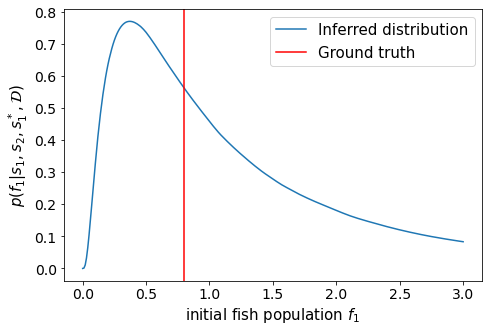

In [ ]:
from scipy.stats import lognorm

grid = 0.01

f1 = np.arange(0.0, 3.0+grid, grid)
pf1_prior = lognorm.pdf(f1,1)
s1 = np.ones(f1.shape) * 2.2
f1_s1 = np.stack((f1, s1), axis=1)
s2_means = decoder.predict(f1_s1).flatten()
ps2_post = [norm.pdf(sol[400,1], loc=i, scale=sigma) for i in s2_means]
pf1_post = np.multiply(ps2_post,pf1_prior)
pf1_post /= np.sum(pf1_post * grid)
pf1_post_mean = np.sum(pf1_post*f1*grid)
print('mean', pf1_post_mean)
print(f1[np.argmax(pf1_post)])

fig = plt.figure(figsize=(7.5,5))
ax = fig.add_subplot(111)
ax.plot(f1,pf1_post, label='Inferred distribution')
ax.set_xlabel('initial fish population $f_1$', fontsize=15)
ax.set_ylabel('$p(f_1|s_1,s_2,s_1^*,\mathcal{D})$', fontsize=15)
ax.axvline(0.8, c='red', label='Ground truth')
ax.legend(fontsize=15)
plt.plot()

fig.savefig("sec2_unsupervised_f1.pdf", bbox_inches='tight')
files.download("sec2_unsupervised_f1.pdf")

# **Briefly on importance of confunders**

The real difficulty of conducting causal inference with observational data is the ability to identify and account for effects of confounders. **Confounders are such variables which affect both the treatment and the outcome**, therefore if we don't know theconfunding effect we cannot infer the exact causal relationship between treatment and the outcome. \\


In the interventional scenario, importance of confunders is very clear.  In Aspirin dosage - headache duration example, a potential confunders could include: headache severity, patient age, or headache type. Knowing something about each of these confunding variables would help us to make a better prediction about headach duration given aspirin dosage. In COVID NPI effectiveness the researchers agregated data from across multiple countries. As the result the confundign effects they had to take into account were: country's population attitude to the pandemic, different demographics across countries, as well as change in attirude towards the regulations and pandemic within individual countries. However, identification of confunding variable is not an easy task and in fact you may never be sure you have idetified all of them. Especially when dealing with **observational and retrospective data**, you have no means to collect additional data about those confunding effects. The one possible approach to account for confounders is via VAE, where you try to infer the latent distribution of confunding variables from some proxy data you have available (encoder). Then you use the sample from that latent confunder distribution in modeling for your problem of interest (decoder). \\



# **Confunding variables in predator-prey model**

In the **predator-prey** case it's not straightforward to introduce confunders. Thus far, initial populations were sampled independently, thus with the current data generating process we are unable to introduce a confunding effect which will afeect both initial population (treated variable) and current population (outcome). I believe a better data generating process should look something like:

1.   Sample initial conditions f0, s0
2.   Sample categorical season confounder: `{'spring', 'summer', 'fall', 'winter'}`
3.   Run ODE solver for X steps -> sample: f1, s1
4.   Run ODE solver for another X steps -> sample: f2, s2


### **Later extensions**
To start with, we consider a confunding effects of seasonal variation in seal and fish, growth and death rates (at later stage we might also consider confounding effect of seal and fish migration as well as extend the model to more animal populations, i.e. a polar bear <- equations to all of these ideas (migration ODE, many-population Lotka-Voldera ODE) are already provided in our FB chat).


\\

### **Clarification to students nomenclature**
In students paper $s_2^*$ is a pre-cull seal population and $s_2$ is the post cull population (earlier I had them switched around... sorry, ~Janek). We should stick to student's nomenclature (although i don't think it changes anything).

### **Things we need to think about :**

1.   During inference, $s_1$ is the culled seal population. Now, that we sample f0 and s0 and use them to obtain s1 and f1, we should think about how the cull happens. Should we obtain s1 and f1 and then subtract some value from s1 to account for the cull? Or does it not matter? As you will see in the bayesian network below, I assumed $s1^*$ to be some pre-cull seal population which is independent of f0 and s0. However maybe it makes more sense to make s1 independent, or leave it as it is but then subtract some **cull** value from the s1. Also since $s1^*$ is **pre-cull** seal population it makes sense to make it dependent on the s0 and f0.
2.   If our latent variable is categorical (season), then it seems like the integral could be actually a tractable sum (there are countable number of SE states which we could sum over) : \\
$$
\begin{aligned}
p(s_2|s_1,f_1,\theta) &= \int p(SE|\theta)p(s_2|s_1,f_1,SE,\theta)dSE \\
&= \sum_{i=0}^{N=3} p(SE_i|\theta)p(s_2|s_1,f_1,SE_i,\theta)
\end{aligned}
$$
However how do we conduct modeling in suhc scenario? Is $p(SE_i|\theta)=0.25$ ? Also, if $SE_i$ is latent, can we determine $p(s_2|s_1,f_1,SE_i,\theta)$?
3.   What is the difference to VAE modeling procedure when the latent confunder variable is not continously distributed? When we have a continous latent confunder, then the decoder learns mean and variance of it's distribution. **However, when we have a ctegorical variable (season) with 4 states, what should the VAE encoder learn to predict?** Should that be: a softmax over states? (if yes, then do we sample from that softmax distribution or take sample with highest probability).

# **Janek - 22/01/2021**
# **Wenlin - 24/01/2021**
# Migration Confounder - f_1 and z observable in Dataset for modeling 


In [ ]:
# season_confounder = {}
# gamma1, gamma2, gamma3, gamma4 = 0.015, 0.012, 0.007, 0.009  # basic case

# # Each season has a different population death/growth rates (ODE predator-prey dynamics are varied)
# # We start with default: gamma1, gamma2, gamma3, gamma4 and add little adjustments as described below
# season_confounder['spring'] = (gamma1 , gamma2, gamma3, gamma4 + 0.002)  # some now born seals mayn not survive -> increased seal death rate 
# season_confounder['summer'] = (gamma1 + 0.005, gamma2, gamma3, gamma4)  # there is more algea -> fish growth increased
# season_confounder['fall'] = (gamma1, gamma2 + 0.002, gamma3, gamma4)  # pregnant seals mothers eat more fish to -> incresed fish death rate
# season_confounder['winter'] = (gamma1, gamma2, gamma3 + 0.003, gamma4)  # seals breed pups -> increased seal growth rate

### **Simple migration effect**
We make migration of seal to be normally distributed. Positive means inflow of seal, Negative means outflow of seal.

**Wenlin: I updated the code for the ground truth plot. Note that we assume $f_1$ and $s_1$, $s_1^*$ were on day 0. So $s_0$ and $f_0$ were on day $-500$.**

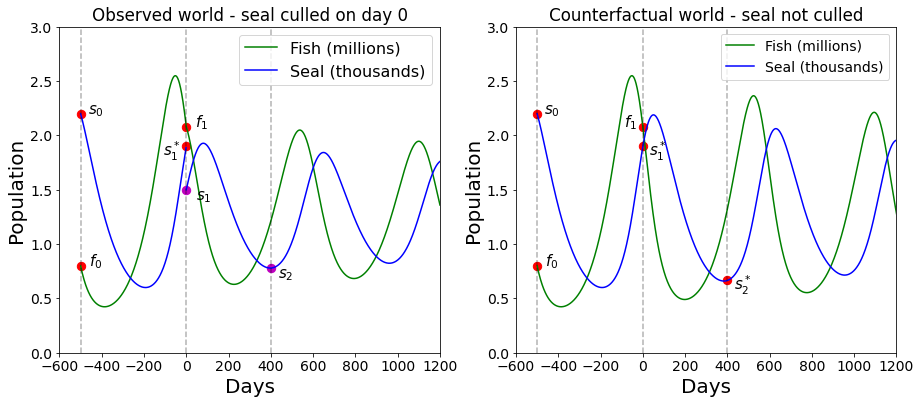

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from google.colab import files

# define the ODEs
def odes(x,t,*args):
  f, s = x
  gamma1, gamma2, gamma3, gamma4, migration = args
  dfdt = gamma1*f - gamma2*f*s 
  dsdt = gamma3*f*s - gamma4*s + migration
  return dfdt, dsdt

# time (days): 0-1499 days
t = np.linspace(0, 3000, 3000)

# parameters of the differential equations:
migration = 0.0005 #np.random.normal(scale=0.001)
gammas = 0.015, 0.012, 0.007, 0.009, migration

# plt figure for plotting the solutions
plot_titles = ["Observed world - seal culled on day 0", 
         "Counterfactual world - seal not culled"]


fig = plt.figure(figsize=(15,6))

# Initial conditions
# f0 = 0.8
# s0 = 2.2

# Counterfactual world (run ode)
# f1 = 2.08
# s1^* = 1.90
# s2^* = 0.67

# Observed world (intervention)
# cull seal popultion to s1 = 1.5


  # # add a subplot
  # ax = fig.add_subplot(1,2,i+1)
  # ax.plot(t, sol[:,0], 'green', label='Fish (millions)')
  # ax.plot(t, sol[:,1], 'blue', label='Seal (thousands)')
  # # ax.grid()
  # ax.legend(loc=1, fontsize=15)
 

  # plt.xlim(-50,1500)
  # plt.ylim(0,5)

  # ax.set_title(plot_titles[i], fontsize=15)
  # ax.axvline(400, linestyle='--', c='k', alpha=0.5)
  # # ax.axhline(sol[400,1], c='red')





# solve the ODEs for the counterfactual world
x0 = (0.8, 2.2)
sol_c = odeint(odes, x0, t, args=gammas)

ax = fig.add_subplot(1,2,2)
ax.plot(t-500, sol_c[:,0], 'green', label='Fish (millions)')
ax.plot(t-500, sol_c[:,1], 'blue', label='Seal (thousands)')
ax.legend()
ax.set_xlabel("Days", fontsize=20)
ax.set_ylabel("Population", fontsize=20)
ax.set_title(plot_titles[1])

ax.set_xlim(-600, 1200)
ax.set_ylim(0.0, 3.0)

ax.axvline(-500, linestyle='--', c='k', alpha=0.3)
ax.axvline(0, linestyle='--', c='k', alpha=0.3)
ax.axvline(400, linestyle='--', c='k', alpha=0.3)

plt.scatter(-500, sol_c[0,0], color='red',s=70)
plt.scatter(-500, sol_c[0,1], color='red',s=70)
plt.annotate('$f_0$', (-500, sol_c[0,0]), textcoords="offset points", xytext=(15,0), ha='center', fontsize=15)
plt.annotate('$s_0$', (-500, sol_c[0,1]), textcoords="offset points", xytext=(15,0), ha='center', fontsize=15)

plt.annotate('$f_1$', (0, sol_c[500,0]), textcoords="offset points", xytext=(-12,0), ha='center', fontsize=15)
plt.scatter(0, sol_c[500,1], color='red',s=70)
plt.scatter(0, sol_c[500,0], color='red',s=70)

plt.scatter(400, sol_c[900,1], color='red',s=70)
plt.annotate('$s_2^*$', (400, sol_c[900,1]), textcoords="offset points", xytext=(15,-10), ha='center', fontsize=15)
plt.annotate('$s_1^*$', (0, sol_c[500,1]), textcoords="offset points", xytext=(15,-10), ha='center', fontsize=15)





# solve the ODEs for the observed world
x0 = (sol_c[500,0], 1.5) # cull seal popultion to s1 = 1.5
sol_o = odeint(odes, x0, t, args=gammas)

ax = fig.add_subplot(1,2,1)
ax.plot(t[:500]-500, sol_c[:500,0], 'green')
ax.plot(t[:500]-500, sol_c[:500,1], 'blue')
ax.plot(t, sol_o[:,0], 'green', label='Fish (millions)')
ax.plot(t, sol_o[:,1], 'blue', label='Seal (thousands)')
ax.legend(loc=1, fontsize=16)
ax.set_xlabel("Days", fontsize=20)
ax.set_ylabel("Population", fontsize=20)
ax.set_title(plot_titles[0])

ax.set_xlim(-600, 1200)
ax.set_ylim(0.0, 3.0)

ax.axvline(-500, linestyle='--', c='k', alpha=0.3)
ax.axvline(0, linestyle='--', c='k', alpha=0.3)
ax.axvline(400, linestyle='--', c='k', alpha=0.3)

plt.scatter(-500, sol_c[0,0], color='red',s=70)
plt.scatter(-500, sol_c[0,1], color='red',s=70)
plt.annotate('$f_0$', (-500, sol_c[0,0]), textcoords="offset points", xytext=(15,0), ha='center', fontsize=15)
plt.annotate('$s_0$', (-500, sol_c[0,1]), textcoords="offset points", xytext=(15,0), ha='center', fontsize=15)

plt.annotate('$f_1$', (0, sol_o[0,0]), textcoords="offset points", xytext=(15,0), ha='center', fontsize=15)
plt.scatter(0, sol_o[0,1], color='m',s=70)
plt.scatter(0, sol_o[0,0], color='red',s=70)
plt.scatter(0, sol_c[500,1], color='red',s=70)

plt.scatter(400, sol_o[400,1], color='m',s=70)
plt.annotate('$s_2$', (400, sol_o[400,1]), textcoords="offset points", xytext=(15,-10), ha='center', fontsize=15)
plt.annotate('$s_1^*$', (-140, sol_c[500,1]), textcoords="offset points", xytext=(15,-10), ha='center', fontsize=15)
plt.annotate('$s_1$', (0, sol_o[0,1]), textcoords="offset points", xytext=(17,-10), ha='center', fontsize=15)


plt.show()
fig.savefig("ground_truth_sec4.pdf", bbox_inches='tight')
files.download("ground_truth_sec4.pdf")

In [ ]:
sol_c[0,0]

0.8

## Data Generation

In [ ]:
np.random.seed(100)  # random seed for reproducibility

dataset_M_0 = []
dataset_M_pos1 = []
dataset_M_pos2 = []
num_data = 5000  # the number of data points to be sampled
seasons = ['spring', 'summer', 'fall', 'winter']

t = np.linspace(0, 1500, 1500)

migration = 0.001 #np.random.normal(scale=0.001)
gammas = 0.015, 0.012, 0.007, 0.009, migration

for dataset, migration in zip([dataset_M_0, dataset_M_pos1, dataset_M_pos2], [0,0.001,0.002]):
  for i in range(num_data):
    gammas = 0.015, 0.012, 0.007, 0.009, migration

    # 1) SAMPLE: f0, s0
    f0 = np.random.lognormal()
    s0 = np.random.lognormal()
    x0 = (f0, s0)

    # 2) SAMPLE: f1, s1
    sol = odeint(odes, x0, t, args=gammas)
    f1 = sol[500,0]
    s1 = sol[500,1]


    # 3) SAMPLE: f2, s2  -  simplified approach
    f2 = sol[900,0]
    s2 = sol[900,1]

    # # 3) SAMPLE: f2, s2  -  initial approach
    # f2 = sol[2*400,0]
    # s2 = sol[2*400,1]


    dataset.append((f1,s1,f2,s2))

  dataset = np.array(dataset)  # Data matrix D of size N x 4 (f1,s1,f2,s2)
  # print('Shape: ', str(dataset.shape))
  # print(dataset[:10])

In [ ]:
dataset_M_0 = np.array(dataset_M_0)
dataset_M_pos1 = np.array(dataset_M_pos1)
dataset_M_pos2 = np.array(dataset_M_pos2)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

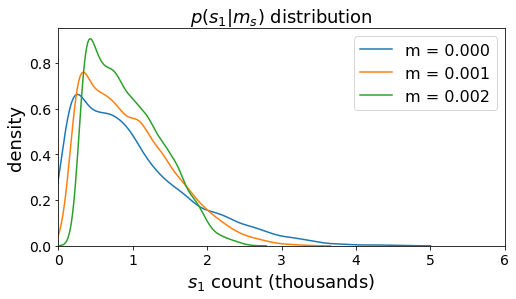

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

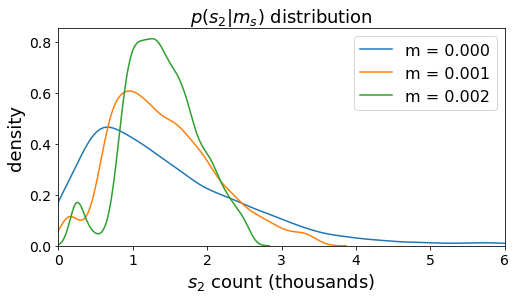

In [ ]:
# VISUALISE P(S1) AND P(S2)
import seaborn as sns
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(8,4))
sns.distplot(dataset_M_0[:,1], hist=False, label='m = 0.000')
sns.distplot(dataset_M_pos1[:,1], hist=False, label='m = 0.001')
sns.distplot(dataset_M_pos2[:,1], hist=False, label='m = 0.002')
plt.legend(fontsize=16)
plt.xlim((0,6))
plt.title('$p(s_1|m_s)$ distribution', fontsize=18)
plt.ylabel('density', fontsize=18)
plt.xlabel('$s_1$ count (thousands)', fontsize=18)
plt.show()

plt.figure(figsize=(8,4))
sns.distplot(dataset_M_0[:,3], hist=False, label='m = 0.000')
sns.distplot(dataset_M_pos1[:,3], hist=False, label='m = 0.001')
sns.distplot(dataset_M_pos2[:,3], hist=False, label='m = 0.002')
plt.legend(fontsize=16)
plt.xlim((0,6))
plt.title('$p(s_2|m_s)$ distribution', fontsize=18)
plt.ylabel('density', fontsize=18)
plt.xlabel('$s_2$ count (thousands)', fontsize=18)
plt.show()

## **Note: migration confounder should be positive**
When migration is negative then the system is unstable and both s and f get pretty high values. So we will model migration with a normal distribution and shifted mean (so it is positive) \\

However the value of m shouldn't be higher then 0.004 as then the populations decay too quickly... so we will use N(0.001,sigma=0.0001)
<!-- log[N(-6.8,0.3)] -->

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


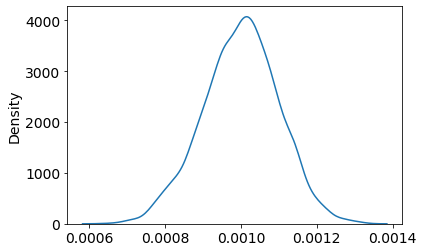

In [ ]:
sns.distplot(list(np.random.normal(loc=0.001, scale=0.0001, size=5000)), hist=False)


In [ ]:
np.random.seed(100)  # random seed for reproducibility

dataset = []
num_data = 5000  # the number of data points to be sampled

t = np.linspace(0, 1500, 1500)

migration = 0.001 #np.random.normal(scale=0.001)
gammas = 0.015, 0.012, 0.007, 0.009, migration

for i in range(num_data):
  migration = np.random.normal(loc=0.001, scale=0.0001)
  gammas = 0.015, 0.012, 0.007, 0.009, migration

  # 1) SAMPLE: f0, s0
  f0 = np.random.lognormal()
  s0 = np.random.lognormal()
  x0 = (f0, s0)

  # 2) SAMPLE: f1, s1
  sol = odeint(odes, x0, t, args=gammas)
  f1 = sol[500,0]
  s1 = sol[500,1]


  # 3) SAMPLE: f2, s2  -  simplified approach
  f2 = sol[900,0]
  s2 = sol[900,1]

  # # 3) SAMPLE: f2, s2  -  initial approach
  # f2 = sol[2*400,0]
  # s2 = sol[2*400,1]


  dataset.append((f0,s0,f1,s1,f2,s2, migration))

dataset = np.array(dataset)  # Data matrix D of size N x 7 (f0,s0,f1,s1,f2,s2,m_s)
print('Shape: ', str(dataset.shape))
print(dataset[:10])

Shape:  (5000, 7)
[[1.40871847e+00 3.16779513e+00 2.43000721e+00 6.02443493e-01
  4.25018317e-01 7.35594651e-01 8.25023453e-04]
 [2.66797775e+00 1.67233164e+00 1.84044531e+00 7.33700434e-01
  5.89911666e-01 9.13200064e-01 9.74756396e-04]
 [3.42993655e-01 8.27376166e-01 4.72516756e-01 1.61455234e+00
  2.22108306e+00 1.35359687e+00 1.02211797e-03]
 [6.32530407e-01 1.54521566e+00 1.11408523e+00 1.78251566e+00
  1.63061293e+00 1.04185387e+00 1.02550014e-03]
 [2.26335239e+00 1.95956166e+00 2.07497663e+00 8.64343227e-01
  6.78260234e-01 8.46618484e-01 9.41640495e-04]
 [5.87851816e-01 2.80031717e+00 2.91134464e+00 1.03725480e+00
  6.15225175e-01 6.52395397e-01 9.89558886e-04]
 [3.26828979e-01 5.04794718e+00 3.13679881e-01 1.88454814e-01
  2.42377720e-01 2.37375752e+00 9.56186438e-04]
 [7.77338682e-01 4.30660269e-01 4.14132255e-01 8.54540416e-01
  1.07298483e+00 2.09916702e+00 1.15416052e-03]
 [2.55252279e+00 2.07715744e+00 1.96736894e+00 7.05153471e-01
  5.48583125e-01 8.71060504e-01 1.018451

# **We only consider fully observable dataset to make things easier**

Todo: \\
1a.  make a NN to model p(s2|f1,s1,ms) \\
1b.  compare p(s2|f1,s1,ms) to ground truth distriution. Comment on accuracy of modelign as compared to the case where there was no confounder.

2. do the inference.

### FORMAT DATA for $p(s_2|f_1,s_1,m_s)$

In [ ]:
# TRAIN - TEST SPLIT
data_split = 0.8
split_index = int(0.8 * dataset.shape[0])

# TRAIN
train__f1_s1_m = dataset[:split_index,[2,3,6]].astype('float32')
train__s2 = dataset[:split_index,5].astype('float32')

# TEST
test__f1_s1_m = dataset[split_index:,[2,3,6]].astype('float32')
test__s2 = dataset[split_index:,5].astype('float32')

### MODEL

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Layer,Dense, Dropout, Activation

def simple_baseline_DNN(input_shape=(3)):
  model_input = Input(shape=input_shape)  # a vector: [f1,s1,m]

  x = Dense(100, activation='relu')(model_input)
  x = Dense(100, activation='relu')(x)

  mean_s2 = Dense(1, activation="linear")(x)
  model = Model(inputs=model_input, outputs=mean_s2, name='simple_FC_network')
  return model

In [ ]:
model_s2_given_f1_s1_m = simple_baseline_DNN(input_shape=(3))  # [f1,s1,m]

model_s2_given_f1_s1_m.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[keras.metrics.MeanSquaredError()])
history_s2 = model_s2_given_f1_s1_m.fit(train__f1_s1_m, train__s2, 
          validation_data=(test__f1_s1_m, test__s2), epochs=50)

Epoch 1/50
125/125 [==============================] - 1s 3ms/step - loss: 1.2843 - mean_squared_error: 1.2843 - val_loss: 0.2997 - val_mean_squared_error: 0.2997
Epoch 2/50
125/125 [==============================] - 0s 2ms/step - loss: 0.2582 - mean_squared_error: 0.2582 - val_loss: 0.2110 - val_mean_squared_error: 0.2110
Epoch 3/50
125/125 [==============================] - 0s 2ms/step - loss: 0.2314 - mean_squared_error: 0.2314 - val_loss: 0.1613 - val_mean_squared_error: 0.1613
Epoch 4/50
125/125 [==============================] - 0s 2ms/step - loss: 0.1410 - mean_squared_error: 0.1410 - val_loss: 0.1129 - val_mean_squared_error: 0.1129
Epoch 5/50
125/125 [==============================] - 0s 2ms/step - loss: 0.1050 - mean_squared_error: 0.1050 - val_loss: 0.0741 - val_mean_squared_error: 0.0741
Epoch 6/50
125/125 [==============================] - 0s 2ms/step - loss: 0.0560 - mean_squared_error: 0.0560 - val_loss: 0.0404 - val_mean_squared_error: 0.0404
Epoch 7/50
125/125 [========

In [ ]:
show = 10

# VISUALISATION OF MODEL
y_pred = model_s2_given_f1_s1_m.predict(test__f1_s1_m)
for true, pred in zip(test__s2[:show], y_pred[:show]):
  print('True: ', str(true), '  ', 'Pred: ', str(pred[0]))

True:  1.054352    Pred:  1.0156835
True:  0.81889826    Pred:  0.7511342
True:  3.4234164    Pred:  3.4753497
True:  1.8028339    Pred:  1.7886482
True:  2.4933496    Pred:  2.5170996
True:  1.2404481    Pred:  1.201376
True:  2.5946136    Pred:  2.6284554
True:  0.62655234    Pred:  0.5552359
True:  1.3659163    Pred:  1.3357644
True:  1.2121577    Pred:  1.1744474


In [ ]:
# Learn p(f1|s0,f0,m)
# TRAIN
train__f0_s0_m = dataset[:split_index,[0,1,6]].astype('float32')
train__f1 = dataset[:split_index,2].astype('float32')

# TEST
test__f0_s0_m = dataset[split_index:,[0,1,6]].astype('float32')
test__f1 = dataset[split_index:,2].astype('float32')

# MODEL
model_f1_given_f0_s0_m= simple_baseline_DNN(input_shape=(3))  # [f0,s0,m]

model_f1_given_f0_s0_m.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[keras.metrics.MeanSquaredError()])
history_f1 = model_f1_given_f0_s0_m.fit(train__f0_s0_m, train__f1, 
          validation_data=(test__f0_s0_m, test__f1), epochs=50)

Epoch 1/50
125/125 [==============================] - 1s 3ms/step - loss: 1.0804 - mean_squared_error: 1.0804 - val_loss: 0.4453 - val_mean_squared_error: 0.4453
Epoch 2/50
125/125 [==============================] - 0s 2ms/step - loss: 0.3820 - mean_squared_error: 0.3820 - val_loss: 0.1719 - val_mean_squared_error: 0.1719
Epoch 3/50
125/125 [==============================] - 0s 2ms/step - loss: 0.1746 - mean_squared_error: 0.1746 - val_loss: 0.1214 - val_mean_squared_error: 0.1214
Epoch 4/50
125/125 [==============================] - 0s 2ms/step - loss: 0.1303 - mean_squared_error: 0.1303 - val_loss: 0.1199 - val_mean_squared_error: 0.1199
Epoch 5/50
125/125 [==============================] - 0s 2ms/step - loss: 0.1011 - mean_squared_error: 0.1011 - val_loss: 0.0827 - val_mean_squared_error: 0.0827
Epoch 6/50
125/125 [==============================] - 0s 2ms/step - loss: 0.1118 - mean_squared_error: 0.1118 - val_loss: 0.0540 - val_mean_squared_error: 0.0540
Epoch 7/50
125/125 [========

In [ ]:
show = 10

# VISUALISATION OF MODEL
y_pred = model_f1_given_f0_s0_m.predict(test__f0_s0_m)
for true, pred in zip(test__f1[:show], y_pred[:show]):
  print('True: ', str(true), '  ', 'Pred: ', str(pred[0]))

True:  0.82288307    Pred:  0.8381407
True:  2.1765454    Pred:  2.1691234
True:  0.1137833    Pred:  0.053278632
True:  0.5163168    Pred:  0.43211204
True:  0.28836957    Pred:  0.31091174
True:  1.1638628    Pred:  1.1739751
True:  0.26385263    Pred:  0.25228226
True:  2.910511    Pred:  2.9519308
True:  0.9376236    Pred:  0.99229646
True:  1.1217568    Pred:  1.1914641


# **Inference**



$$
\begin{align*}
    &p(s_2^*|f_0,s_0,s_1,s_2,s_1^*,\mathcal{D}) \\
    \propto~& \mathbb{E}_{p(m_s)}\left\{
    \mathbb{E}_{p(f_1|f_0,s_0,m_s)}\left[p_{\theta_{ML}}(s_2^*|s_1^*,f_1,m_s)p_{\theta_{ML}}(s_2|s_1,f_1,m_s)\right] \mathbb{E}_{p(f_1|f_0,s_0,m_s)}\left[ p_{\theta_{ML}}(s_2|s_1,f_1,m_s) \right] \right\}\\
    \approx~& \frac{1}{V}\sum_{v=1}^V \left[ \frac{1}{L}\sum_{l=1}^L \left( p_{\theta_{ML}}(s_2^*|s_1^*,f_1^{(l,v)},m_s^{(v)})p_{\theta_{ML}}(s_2|s_1,f_1^{(l,v)},m_s^{(v)})
    \right) \frac{1}{L}\sum_{l=1}^L p_{\theta_{ML}}(s_2|s_1,f_1^{(l,v)},m_s^{(v)}) \right]
    , \\
    \quad~& \left(m_s^{(v)}\sim p(m_s), \quad f_1^{(l,v)}\sim p_{\theta_{ML}}(f_1|f_0,s_0,m_s^{(v)})\right) \\
    \propto~& \frac{1}{V} \sum_{v=1}^V \left[ \left( \frac{1}{L} \sum_{l=1}^Lw^{(l,v)}p_{\theta_{ML}}(s_2^*|s_1^*,f_1^{(l,v)},m_s^{(v)}) \right) \left( \frac{1}{L} \sum_{l=1}^Lw^{(l,v)} \right) \right],\\
    \quad~& \left(w^{(l,v)}= p_{\theta_{ML}}(s_2|s_1,f_1^{(l,v)},m_s^{(v)})\right).
\end{align*}
$$
**~Wenlin: I think that it should be $f_1^{(l,v)}$ rahter than $f_1^{(l)}$, since the conditional distribution of $f_1$ also depends on $m_s$ which is approximated by samples $m_s^{(v)}$. I have corrected the formula above.**
<!-- &\approx \sum_{l=1}^L\pi^{(l)}p(s_2^*|s_1^*,f_1^{(l)},\theta_{ML}),\quad \pi^{(l)}=\frac{w^{(l)}}{\sum_{j=1}^Lw^{(j)}}. -->

mean 0.6572769488408232
true 0.6655788648489611
66


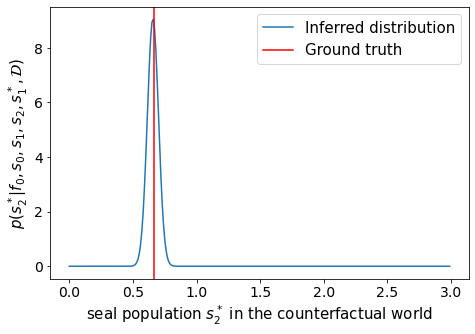

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from scipy.stats import norm
vector_length = 100 #L=V=100

#sigma = 0.1
sigma_f1 = history_f1.history['val_mean_squared_error'][-1] ** 0.5
sigma_s2 = history_s2.history['val_mean_squared_error'][-1] ** 0.5

# Set the initial condition s0 and f0
s0 = np.ones(vector_length) * 2.2  # known constant - initial condition
f0 = np.ones(vector_length) * 0.8  # known constant - initial condition

# Sample m_s^{(v)} from p(m_s)
m_sample = np.random.normal(loc=0.001, scale=0.0001, size=vector_length)


# Sample f_1^{(l,v)} from p(f1|s0,f0,m_s^{(v)})
f_1_samples = np.zeros([vector_length, vector_length])
for l in range(vector_length):
  f0_s0_m_samples = np.stack((f0, s0, m_sample), axis=1)
  f_1_samples[l,:] = model_f1_given_f0_s0_m.predict(f0_s0_m_samples).flatten()

# 1) Compute the mean of p(s2|s1,f1^(l,v),ms^(v))
s1 = np.ones(vector_length) * 1.5
s2_means = np.zeros([vector_length, vector_length])
for l in range(vector_length):
  f1_s1_m = np.stack((f_1_samples[l,:], s1, m_sample), axis=1)
  s2_means[l,:] = model_s2_given_f1_s1_m.predict(f1_s1_m).flatten()

# 2) Compute the mean of p(s2*|s1*,f1^(i),ms^(v))
s1_star = np.ones(vector_length) * sol_c[500,1]
s2_star_means = np.zeros([vector_length, vector_length])
for l in range(vector_length):
  f1_s1_star_m = np.stack((f_1_samples[l,:], s1_star, m_sample), axis=1)
  s2_star_means[l,:] = model_s2_given_f1_s1_m.predict(f1_s1_star_m).flatten()



# 3) Evaluate w^(l,v) = p(s2=sol_o[400,1]|s1,f1^{(i)})

w = np.zeros([vector_length, vector_length])
for l in range(vector_length):
  for v in range(vector_length):
    w[l,v] = norm.pdf(sol_o[400,1], loc=s2_means[l,v], scale=sigma_s2)


# 4) Mixture of Gaussian
x_line = np.arange(0.0, 3.0, 0.01)
y_line_list = []
for v in range(vector_length):
  y_line = w[0,v] * norm.pdf(x_line, loc=s2_star_means[0,v], scale=sigma_s2)
  for l in range(1,vector_length):
    y_line += w[l,v] * norm.pdf(x_line, loc=s2_star_means[l,v], scale=sigma_s2) # sum over l=1:L
  y_line *= np.sum(w[:,v], axis=0)
  y_line_list.append(y_line)
y_line = np.array(y_line_list).sum(axis=0) # sum over v=1:V
y_line /= np.sum(y_line*0.01) # normalizing
mean_y = np.sum(x_line*y_line*0.01)
print('mean', mean_y)
print('true', sol_c[900,1])
print(np.argmax(y_line))

# 5) Plot

fig = plt.figure(figsize=(7.5,5))
ax = fig.add_subplot(111)
ax.plot(x_line, y_line, label='Inferred distribution')
ax.set_xlabel('seal population $s_2^*$ in the counterfactual world', fontsize=15)
ax.set_ylabel('$p(s_2^*|f_0,s_0,s_1,s_2,s_1^*,\mathcal{D})$', fontsize=15)
ax.axvline(sol_c[900,1], c='red', label='Ground truth')
ax.legend(fontsize=15)
plt.show()

fig.savefig("sec4_supervised_s2star.pdf", bbox_inches='tight')
files.download("sec4_supervised_s2star.pdf")

<!-- 

TEXT BELOW IS ABOUT SEASONAL CONFOUNDER - AND IS OLD

Simple NN with information about SE scores validation **MSE=0.676**. As can be seen in the visualisation above the results are far from great given that the this is a simple supervised learning task of: $p(s2|f1,s1,SE)$
(For comparison we recall that in case with no confunder the MSE was **0.0162** which is significantly lower!). \\

I hypothesize that the extra one hot encoded SE features pose a harder mapping task and perhaps our network is too shallow (Learning converged after 40 epochs). OR perhaps, because there are in fact 4 different distributions (for 4 different seasons) we need more datapoints to be able to learn the relationship. Alternativelly, we could normalise s1 and f1 before feeding to the network (s1 and f1 are not exteemly high but numbers as high as 4 happen and I believe this would help with parameter estimation, as SE values are 0 or 1).


Just for comparison let's see what performance we could get for the dataset with observed SE confunder, if we have simply diregarded conditioning on **SE** and just modeled: $p(s2|f1,s1)$ -->
